### Import librairies

In [1]:
# Main libraries
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager

# Libraries for vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Library for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

### Define path for each dataset

In [2]:
# Define paths for each dataset
application_test_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv"
application_train_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv"
bureau_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv"
bureau_balance_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv"
credit_card_balance_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv"
HomeCredit_columns_description_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv"
installments_payments_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv"
POS_CASH_balance_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv"
previous_application_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv"
sample_submission_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/sample_submission.csv"

# Feature engineering functions

### Kernel 'LightGBM with Simple Features' is used as base for feature engineering

Most features are created by applying min, max, mean, sum and var functions to grouped tables. 

Little feature selection is done and overfitting might be a problem since many features are related.  

The following key ideas were used:
- Divide or subtract important features to get rates (like annuity and income)
- In Bureau Data: create specific features for Active credits and Closed credits
- In Previous Applications: create specific features for Approved and Refused applications
- Modularity: one function for each table (except bureau_balance and application_test)
- One-hot encoding for categorical features

All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).

In [3]:
@contextmanager
# Timer function
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    
    """"
    Parameters
    ----------
    df : pandas dataframe 
        dataframe containing categorical columns/features
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
        
    Returns
    -------
    df : pandas dataframe
        one_hot_encoded dataframe
    new_columns : list
        new list of all the columns in the above new dataframe
    """
    
    # Create the list of all the columns
    original_columns = list(df.columns)
    # Create the list of categorical_columns for further one_hot_encoding
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # One_hot_encoding
    df = pd.get_dummies(df, 
                        columns = categorical_columns, # apply one_hot_encoder to categorical columns only 
                        dummy_na = nan_as_category, # if True, add a column to indicate NaNs
                        drop_first = False) # if True, remove the first categorical level
    # Create the new list of all the columns after one_hot_encoding categorical features
    new_columns = [c for c in df.columns if c not in original_columns]
    
    return df, new_columns


In [4]:
def bureau_and_balance(nan_as_category = True):
    
    """
    Parameters
    ----------
    sep : string
        Delimiter used in the csv files
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    bureau_agg : pandas dataframe
        New dataframe created by merging bureau, bureau_balance and aggregated dataframes, 
        one-hot encoding
    """
    
    # Read data
    bureau = pd.read_csv(bureau_path, sep = ',')
    bb = pd.read_csv(bureau_balance_path, sep = ',')
    
    # Categorical features with One-Hot encode
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    # Create aggregated dataframe with new columns : min, max and size for MONTHS_BALANCE and mean for bb_cat features
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    # Keep just one title by column
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    # Merge bureau and bb_agg
    bureau = bureau.join(bb_agg, how = 'left', on = 'SK_ID_BUREAU')
    # Drop column 'SK_ID_BUREAU'
    bureau.drop(['SK_ID_BUREAU'], axis = 1, inplace = True)
    # Delete bb and bb_agg (Just keep bureau after aggregation)
    del bb, bb_agg
    ### gc.collect() ?
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    # Create aggregated dataframe with new columns: mean for bb_cat and bureau_cat features 
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    # Keep just one title by column
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    # Create aggregated dataframe with new columns : min, max, var, mean, sum for numeric features
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    # Keep just one title by column
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    # Merge bureau_agg and active_agg
    bureau_agg = bureau_agg.merge(active_agg, how='left', on='SK_ID_CURR')
    # Delete active and active_agg (keep only bureau_agg)
    del active, active_agg
    ### gc.collect() ?
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    # Create aggregated dataframe with new columns : min, max, var, mean, sum for numeric features
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    # Keep just one title by column
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    # Merge bureau_agg and closed_agg
    bureau_agg = bureau_agg.merge(closed_agg, how='left', on='SK_ID_CURR')
    # Delete closed, closed_agg and bureau (keep only bureau_agg)
    del closed, closed_agg, bureau
    ### gc.collect() ?
    return bureau_agg

In [5]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(nan_as_category = False):
    
    """
    Parameters
    ----------
    sep : string
        Delimiter used in the csv files
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    df : pandas dataframe
        New dataframe created by merging train and test dataframes, binary and one-hot encoding,
        creating new simple features from AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, etc...
    """
    
    # Read data 
    df = pd.read_csv(application_train_path, sep = ',')
    test_df = pd.read_csv(application_test_path, sep = ',')
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # merge application_train and application_test
    df = df.append(test_df).reset_index()
    # Remove 4 applications with XNA CODE_GENDER (in train set and not in test set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    ### gc.collect() : intérêt ???
    return df

In [6]:
# Preprocess previous_applications.csv
def previous_applications(nan_as_category = True):

    """
    Parameters
    ----------
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    prev_agg : pandas dataframe
        New dataframe created by cleaning previous_application_path, 
        hot_hot_encoding categorical features, aggregating by SK_ID_CURR
    """
    
    # Read data
    prev = pd.read_csv(previous_application_path, sep = ',')
    
    # Categorical features with One-Hot encode
    prev, cat_cols = one_hot_encoder(prev, nan_as_category = True)
    
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace = True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace = True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace = True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace = True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace = True)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum']
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    # Create aggregated dataframe with new columns: mean for cat_cols and min, max, mean, sum for numeric features
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    # Keep just one title by column
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    # Delete refused, refused_agg, approved, approved_agg, prev (keep only prev_agg)
    del refused, refused_agg, approved, approved_agg, prev
    ### gc.collect() ?
    return prev_agg

In [7]:
# Preprocess POS_CASH_balance.csv
def pos_cash(nan_as_category = True):
    
    """
    Parameters
    ----------
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    pos_agg : pandas dataframe
        New dataframe created by cleaning previous_application_path, 
        one_hot_encoding categorical features, aggregating by SK_ID_CURR
    """
    
    # Read data
    pos = pd.read_csv(POS_CASH_balance_path, sep = ',')
    
    # Categorical features with One-Hot encode
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    # numeric features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    # categorical features
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Create aggregated dataframe with new columns: mean for cat_cols and max, mean, size for numeric features
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    # Delete pos (keep only pos_agg)
    del pos
    ### gc.collect() ??
    return pos_agg

In [8]:
# Preprocess installments_payments.csv
def installments_payments(nan_as_category = True):
    
    """
    Parameters
    ----------
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    ins_agg : pandas dataframe
        New dataframe created by cleaning previous_application_path, 
        one_hot_encoding categorical features, aggregating by SK_ID_CURR
    """
    
    # Read data
    ins = pd.read_csv(installments_payments_path, sep = ',')
    
    # Categorical features with One-Hot encode
    ins, cat_cols = one_hot_encoder(ins, nan_as_category = True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Numeric Features
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    # Categorical features
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Perform aggregations
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # Delete ins (Keep only ins_agg)
    del ins
    ### gc.collect() ???
    return ins_agg

In [9]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    
    """
    Parameters
    ----------
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    cc_agg : pandas dataframe
        New dataframe created by cleaning previous_application_path, 
        one_hot_encoding categorical features, aggregating by SK_ID_CURR
    """
    
    # Read data
    cc = pd.read_csv(credit_card_balance_path, sep = ',')
    
    # Categorical features with One-Hot encode
    cc, cat_cols = one_hot_encoder(cc, nan_as_category = True)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    # Delete cc (keep just cc_agg)
    del cc
    ### gc.collect() ???
    return cc_agg

In [10]:
def main(debug = False):
    
    """
    Parameters
    ----------
    debug : Bool
    
    Returns
    -------
    df : pandas dataframe
        Final dataframe created by cleaning, preparing and merging
        all the dataframes
    """
    
    df = application_train_test()
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance()
        print("Bureau df shape:", bureau.shape)
        df = df.merge(bureau, how = 'left', on = 'SK_ID_CURR')
        del bureau
    with timer("Process previous_applications"):
        prev = previous_applications()
        print("Previous applications df shape:", prev.shape)
        df = df.merge(prev, how = 'left', on = 'SK_ID_CURR')
        del prev
    with timer("Process POS-CASH balance"):
        pos = pos_cash()
        print("Pos-cash balance df shape:", pos.shape)
        df = df.merge(pos, how = 'left', on = 'SK_ID_CURR')
        del pos
    with timer("Process installments payments"):
        ins = installments_payments()
        print("Installments payments df shape:", ins.shape)
        df = df.merge(ins, how = 'left', on = 'SK_ID_CURR')
        del ins
    with timer("Process credit card balance"):
        cc = credit_card_balance()
        print("Credit card balance df shape:", cc.shape)
        df = df.merge(cc, how = 'left', on = 'SK_ID_CURR')
        del cc
    
    train_df = df.loc[df['TARGET'].notnull()]
    test_df = df.loc[df['TARGET'].isnull()]
    
    return df, train_df, test_df

In [11]:
startTime = time.time()

df, train_df, test_df = main(debug = False)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

executionTime_min = executionTime / 60
print('Execution time in minutes: ' + str(executionTime_min))

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 26s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 31s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 14s
Installments payments df shape: (339587, 26)
Process installments payments - done in 29s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 22s
Execution time in seconds: 133.3564121723175
Execution time in minutes: 2.222606869538625


In [12]:
# remove special characters in df feature names
df.columns = df.columns.str.replace(':', '')
df.columns = df.columns.str.replace(',', '')
df.columns = df.columns.str.replace(']', '')
df.columns = df.columns.str.replace('[', '')
df.columns = df.columns.str.replace('{', '')
df.columns = df.columns.str.replace('}', '')
df.columns = df.columns.str.replace('"', '')

# remove special characters in train_df feature names
train_df.columns = train_df.columns.str.replace(':', '')
train_df.columns = train_df.columns.str.replace(',', '')
train_df.columns = train_df.columns.str.replace(']', '')
train_df.columns = train_df.columns.str.replace('[', '')
train_df.columns = train_df.columns.str.replace('{', '')
train_df.columns = train_df.columns.str.replace('}', '')
train_df.columns = train_df.columns.str.replace('"', '')

# remove special characters in test_df feature names
test_df.columns = test_df.columns.str.replace(':', '')
test_df.columns = test_df.columns.str.replace(',', '')
test_df.columns = test_df.columns.str.replace(']', '')
test_df.columns = test_df.columns.str.replace('[', '')
test_df.columns = test_df.columns.str.replace('{', '')
test_df.columns = test_df.columns.str.replace('}', '')
test_df.columns = test_df.columns.str.replace('"', '')

### Evaluate DummyClassifier

In [129]:
# Import necessary functions
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, classification_report

In [130]:
# Create X and y from df
X = df.loc[df['TARGET'].notnull()].drop(['index', 'SK_ID_CURR', 'TARGET'], 1)
y = df.loc[df['TARGET'].notnull()][['TARGET']].values

KeyError: 'TARGET'

In [68]:
# Run DummyClassifier with 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy = 'most_frequent')
# Fit
dummy_clf.fit(X_train, y_train)
# Predict
y_predict = dummy_clf.predict(X_train)

# Calculate and print accuracy score
print('accuracy_score =', dummy_clf.score(y_predict, y_train))
print('----------------')

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_train, y_predict))
print('----------------')

# Print classification report with precision, recall and f1-score for each class
print('classification_report :')
print(' ')
print(classification_report(y_train, y_predict))

accuracy_score = 0.9192701304360551
----------------
roc_auc_score = 0.5
----------------
classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282682
         1.0       0.00      0.00      0.00     24825

    accuracy                           0.92    307507
   macro avg       0.46      0.50      0.48    307507
weighted avg       0.85      0.92      0.88    307507



In [70]:
# Run DummyClassifier with 'stratified' strategy
dummy_clf = DummyClassifier(strategy = 'stratified')
# Fit
dummy_clf.fit(X_train, y_train)
# Predict
y_predict = dummy_clf.predict(X_train)

# Calculate and print accuracy score
print('accuracy_score =', dummy_clf.score(y_predict, y_train))
print('----------------')

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_train, y_predict))
print('----------------')

# Print classification report with precision, recall and f1-score for each class
print('classification_report :')
print(' ')
print(classification_report(y_train, y_predict))

accuracy_score = 0.8510147736474292
----------------
roc_auc_score = 0.5000692822105293
----------------
classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92    282682
         1.0       0.08      0.08      0.08     24825

    accuracy                           0.85    307507
   macro avg       0.50      0.50      0.50    307507
weighted avg       0.85      0.85      0.85    307507



# EDA after feature engineering and merging all the datasets

In [16]:
# Code to display all the columns
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 130
    display.max_rows = 220
    display.max_colwidth = 200
    display.width = None
set_pandas_display_options()


# Show exact values on barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

        
# Create function that counts the observations in each categorical bin using bars
def graph_objects(dataframe, hue = None):
    
    if hue is not None:
        hue = hue
        
    df = dataframe.dtypes
    df.index.name = 'columns'
    df = pd.DataFrame(df, columns = ['dtype'])
    df = df.reset_index()
    df = df[df['dtype'] == 'object']
    list_objects = df['columns'].tolist()
    
    for obj in list_objects:
        plt.figure(figsize = (15,4))
        plot = sns.countplot(obj, data = dataframe, hue = hue)
        plt.xticks(rotation = 90)
        show_values(plot)

In [17]:
# Vizualise df
df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,...,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0000,0.0250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7

In [18]:
# Replace infinite values by NaN in df
df = df.replace([np.inf, -np.inf], np.nan)

In [19]:
# Vizualise train_df
train_df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,...,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.

In [20]:
# Vizualise test_df
test_df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,...,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
307507,0,100001,NaN,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329.0,-5170.0,-812,NaN,1,1,0,1,0,1,2.0,2,2,18,0,0,0,0,0,0,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,1,100005,NaN,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469.0,-9118.0,-1623,NaN,1,1,0,1,0,0,2.0,2,2,9,0,0,0,0,0,0,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [21]:
# Replace infinite values by NaN in train_df and test_df
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)

In [22]:
# Shape of train_df
train_df.shape

(307507, 798)

In [23]:
# sum of all duplicated records in train_df dataset
print('Number of duplicates in train_df dataset:', 
      train_df.duplicated().sum())

Number of duplicates in train_df dataset: 0


In [24]:
# Count and percentage of NaNs in train_df
columns = train_df.isnull().sum().keys()
nans_count = train_df.isnull().sum().values
nans_percentage = train_df.isnull().sum().values/train_df.shape[0]

# create a dataframe from the extracted info. 
nans_df = pd.DataFrame({'Column': columns, 'No. of NaNs': nans_count, 
                        '% of NaNs in Column':nans_percentage * 100})
nans_df = nans_df.sort_values(by = '% of NaNs in Column', 
                              ascending = False)
nans_df

,Column,No. of NaNs,% of NaNs in Column
598,REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.311554
607,REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.311554
606,REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.311554
605,REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.311554
596,REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.311554
...,...,...,...
180,ORGANIZATION_TYPE_Government,0,0.000000
179,ORGANIZATION_TYPE_Emergency,0,0.000000
178,ORGANIZATION_TYPE_Electricity,0,0.000000
177,ORGANIZATION_TYPE_Culture,0,0.000000


In [25]:
# all columns dtypes
train_df.dtypes.value_counts()

float64    622
uint8      133
int64       43
dtype: int64

In [26]:
# Display train_df only with 'int64' features
train_df.select_dtypes('int64')

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,DAYS_BIRTH,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,100002,0,0,0,0,-9461,-2120,1,1,0,1,1,0,2,2,10,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,100003,1,0,1,0,-16765,-291,1,1,0,1,1,0,1,1,11,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,100004,0,1,0,0,-19046,-2531,1,1,1,1,1,0,2,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,100006,1,0,0,0,-19005,-2437,1,1,0,1,0,0,2,2,17,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,100007,0,0,0,0,-19932,-3458,1,1,0,1,0,0,2,2,11,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,307506,456251,0,0,1,0,-9327,-1982,1,1,0,1,0,0,1,1,15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
307503,307507,456252,1,0,0,0,-20775,-4090,1,0,0,1,1,0,2,2,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307504,307508,456253,1,0,0,0,-14966,-5150,1,1,0,1,0,1,3,3,9,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307505,307509,456254,1,0,0,0,-11961,-931,1,1,0,1,0,0,2,2,9,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# Check for missing values (NaN)
train_df.select_dtypes('int64').isna().sum()

index                          0
SK_ID_CURR                     0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
DAYS_BIRTH                     0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_7                0
FLAG_DOCUMENT_8                0
FLAG_DOCUM

-> There are no NaN for 'int64' features

In [28]:
# Display train_df only with 'uint8' features (one_hot_encoded categorical features)
train_df.select_dtypes('uint8')

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse partner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,...,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry type 1,ORGANIZATION_TYPE_Industry type 10,ORGANIZATION_TYPE_Industry type 11,ORGANIZATION_TYPE_Industry type 12,ORGANIZATION_TYPE_Industry type 13,ORGANIZATION_TYPE_Industry type 2,ORGANIZATION_TYPE_Industry type 3,ORGANIZATION_TYPE_Industry type 4,ORGANIZATION_TYPE_Industry type 5,ORGANIZATION_TYPE_Industry type 6,ORGANIZATION_TYPE_Industry type 7,ORGANIZATION_TYPE_Industry type 8,ORGANIZATION_TYPE_Industry type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade type 1,ORGANIZATION_TYPE_Trade type 2,ORGANIZATION_TYPE_Trade type 3,ORGANIZATION_TYPE_Trade type 4,ORGANIZATION_TYPE_Trade type 5,ORGANIZATION_TYPE_Trade type 6,ORGANIZATION_TYPE_Trade type 7,ORGANIZATION_TYPE_Transport type 1,ORGANIZATION_TYPE_Transport type 2,ORGANIZATION_TYPE_Transport type 3,ORGANIZATION_TYPE_Transport type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone brick,WALLSMATERIAL_MODE_Wooden,EMERGENCYS

In [29]:
# Check for missing values (NaN)
train_df.select_dtypes('uint8').isna().sum()

NAME_CONTRACT_TYPE_Cash loans                        0
NAME_CONTRACT_TYPE_Revolving loans                   0
NAME_TYPE_SUITE_Children                             0
NAME_TYPE_SUITE_Family                               0
NAME_TYPE_SUITE_Group of people                      0
NAME_TYPE_SUITE_Other_A                              0
NAME_TYPE_SUITE_Other_B                              0
NAME_TYPE_SUITE_Spouse partner                       0
NAME_TYPE_SUITE_Unaccompanied                        0
NAME_INCOME_TYPE_Businessman                         0
NAME_INCOME_TYPE_Commercial associate                0
NAME_INCOME_TYPE_Maternity leave                     0
NAME_INCOME_TYPE_Pensioner                           0
NAME_INCOME_TYPE_State servant                       0
NAME_INCOME_TYPE_Student                             0
NAME_INCOME_TYPE_Unemployed                          0
NAME_INCOME_TYPE_Working                             0
NAME_EDUCATION_TYPE_Academic degree                  0
NAME_EDUCA

-> There are no NaN for 'uint8' features

In [30]:
# Display train_df only with 'float64' features
train_df.select_dtypes('float64')

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,...,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,1.0,202500.0,406597.5,24700.5,351000.0,0.018801,-637.0,-3648.0,NaN,1.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,0.0149,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,270000.0,1293502.5,3569

In [31]:
# Check for missing values (NaN)
train_df.select_dtypes('float64').isna().mean()

TARGET                              0.000000
AMT_INCOME_TOTAL                    0.000000
AMT_CREDIT                          0.000000
AMT_ANNUITY                         0.000039
AMT_GOODS_PRICE                     0.000904
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX     0.717389
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.717389
CC_NAME_CONTRACT_STATUS_nan_SUM     0.717389
CC_NAME_CONTRACT_STATUS_nan_VAR     0.719444
CC_COUNT                            0.717389
Length: 622, dtype: float64

-> NaN may be replaced by mean or median

In [32]:
# find the most correlated columns for TARGET:
# Drop non informative features 'index' and 'SK_ID_CURR' and then process correlation calculation
data_corr = train_df.drop(['index', 'SK_ID_CURR'] ,1).corr()
# Sort values by correlation coefficient with 'TARGET'
data_corr = data_corr.sort_values(by = 'TARGET', ascending = False)[['TARGET']]

In [33]:
# Create new columns
# Use index names in the new column 'Column'
data_corr['Column'] = data_corr.index
# New feature with the absolute values of correlation coefficient with 'TARGET'
data_corr['absTARGET'] = abs(data_corr['TARGET'])
data_corr.sort_values(by = 'absTARGET', ascending = False)

,TARGET,Column,absTARGET
TARGET,1.000000,TARGET,1.000000
EXT_SOURCE_3,-0.178926,EXT_SOURCE_3,0.178926
EXT_SOURCE_2,-0.160471,EXT_SOURCE_2,0.160471
EXT_SOURCE_1,-0.155317,EXT_SOURCE_1,0.155317
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692
...,...,...,...
CC_NAME_CONTRACT_STATUS_nan_MIN,NaN,CC_NAME_CONTRACT_STATUS_nan_MIN,NaN
CC_NAME_CONTRACT_STATUS_nan_MAX,NaN,CC_NAME_CONTRACT_STATUS_nan_MAX,NaN
CC_NAME_CONTRACT_STATUS_nan_MEAN,NaN,CC_NAME_CONTRACT_STATUS_nan_MEAN,NaN
CC_NAME_CONTRACT_STATUS_nan_SUM,NaN,CC_NAME_CONTRACT_STATUS_nan_SUM,NaN


In [34]:
# Create a dataframe with NaNs and correlation coefficient with 'TARGET'
# Merge nans_df with data_corr
nans_df = nans_df.merge(data_corr, how = 'left')
nans_df

,Column,No. of NaNs,% of NaNs in Column,TARGET,absTARGET
0,REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.311554,-0.016613,0.016613
1,REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.311554,-0.040649,0.040649
2,REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.311554,-0.037088,0.037088
3,REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.311554,-0.039341,0.039341
4,REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.311554,-0.016399,0.016399
...,...,...,...,...,...
793,ORGANIZATION_TYPE_Government,0,0.000000,-0.007521,0.007521
794,ORGANIZATION_TYPE_Emergency,0,0.000000,-0.001458,0.001458
795,ORGANIZATION_TYPE_Electricity,0,0.000000,-0.002945,0.002945
796,ORGANIZATION_TYPE_Culture,0,0.000000,-0.003265,0.003265


In [35]:
# Create a list of features with NaN
list_feat_nan = nans_df.loc[nans_df['No. of NaNs'] != 0]['Column'].values.tolist()
len(list_feat_nan)

616

In [36]:
# Show the 20 most correlated features and their respective % of NaNs
nans_df.sort_values('absTARGET', ascending = False).head(20)

,Column,No. of NaNs,% of NaNs in Column,TARGET,absTARGET
683,TARGET,0,0.000000,1.000000,1.000000
289,EXT_SOURCE_3,60965,19.825565,-0.178926,0.178926
608,EXT_SOURCE_2,660,0.214629,-0.160471,0.160471
218,EXT_SOURCE_1,173376,56.381156,-0.155317,0.155317
24,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,246367,80.117526,0.107692,0.107692
76,CC_CNT_DRAWINGS_CURRENT_MAX,220602,71.738855,0.101389,0.101389
300,BURO_DAYS_CREDIT_MEAN,44020,14.315121,0.089731,0.089731
89,CC_AMT_BALANCE_MEAN,220602,71.738855,0.087177,0.087177
71,CC_AMT_TOTAL_RECEIVABLE_MEAN,220602,71.738855,0.086490,0.086490
72,CC_AMT_RECIVABLE_MEAN,220602,71.738855,0.086478,0.086478


### Dataframe with correlation > 0.02 with TARGET

In [95]:
# Create a list of features with a coefficient higher than 0.02
list_feat_corr002 = data_corr.loc[data_corr['absTARGET'] > 0.02]['Column'].values.tolist()
len(list_feat_corr002)

285

In [98]:
# Create a dataframe with the features of list_feat_corr002
list_feat_corr002.insert(0, 'SK_ID_CURR')
list_feat_corr002.insert(0, 'index')
df_corr002 = df[list_feat_corr002]
df_corr002

,index,SK_ID_CURR,TARGET,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX,BURO_DAYS_CREDIT_MEAN,CC_AMT_BALANCE_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,CC_AMT_INST_MIN_REGULARITY_MEAN,BURO_MONTHS_BALANCE_MIN_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,BURO_DAYS_CREDIT_UPDATE_MEAN,CC_AMT_BALANCE_MAX,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_RECIVABLE_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,REFUSED_DAYS_DECISION_MAX,CC_AMT_BALANCE_MIN,ACTIVE_DAYS_CREDIT_MEAN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_RECIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_CNT_DRAWINGS_CURRENT_VAR,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_MIN,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_DAYS_CREDIT_MIN,BURO_STATUS_1_MEAN_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,REGION_RATING_CLIENT_W_CITY,REFUSED_DAYS_DECISION_MEAN,ACTIVE_DAYS_CREDIT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_MONTHS_BALANCE_SUM,REGION_RATING_CLIENT,CC_AMT_DRAWINGS_CURRENT_MEAN,CLOSED_DAYS_CREDIT_MEAN,NAME_INCOME_TYPE_Working,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_HC_MEAN,APPROVED_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_MAX,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,NAME_EDUCATION_TYPE_Secondary / secondary special,BURO_DAYS_CREDIT_MAX,REFUSED_DAYS_DECISION_MIN,CC_CNT_DRAWINGS_POS_CURRENT_VAR,BURO_DAYS_CREDIT_ENDDATE_MEAN,...,ELEVATORS_MODE,PREV_AMT_ANNUITY_MIN,TOTALAREA_MODE,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MEAN,FLOORSMIN_MODE,LIVINGAREA_MEDI,INSTAL_DBD_SUM,LIVINGAREA_AVG,WALLSMATERIAL_MODE_Panel,FLOORSMIN_MEDI,PREV_RATE_DOWN_PAYMENT_MEAN,FLOORSMIN_AVG,ELEVATORS_MEDI,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MEAN,ELEVATORS_AVG,PREV_NAME_PORTFOLIO_POS_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_AMT_ANNUITY_MEAN,APPROVED_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,POS_COUNT,POS_MONTHS_BALANCE_SIZE,PREV_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MAX,REGION_POPULATION_RELATIVE,PREV_PRODUCT_COMBINATION_Cash X-Sell low_MEAN,ACTIVE_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_VAR,REFUSED_RATE_DOWN_PAYMENT_MIN,AMT_GOODS_PRICE,PREV_RATE_DOWN_PAYMENT_MAX,HOUSETYPE_MODE_block of flats,REFUSED_RATE_DOWN_PAYMENT_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,PREV_NAME_YIELD_GROUP_low_normal_MEAN,EMERGENCYSTATE_MODE_No,CC_CNT_INSTALMENT_MATURE_CUM_SUM,FLOORSMAX_MODE,APPROVED_HOUR_APPR_PROCESS_START_MAX,FLOORSMAX_MEDI,APPROVED_AMT_ANNUITY_MAX,FLOORSMAX_AVG,APPROVED_AMT_ANNUITY_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,ORGANIZATION_TYPE_XNA,NAME_INCOME_TYPE_Pensioner,REFUSED_HOUR_APPR_PROCESS_START_MIN,CODE_GENDER,BURO_STATUS_C_MEAN_MEAN,NAME_EDUCATION_TYPE_Higher education,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CC_MONTHS_BALANCE_VAR,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_COUNT,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,DAYS_EMPLOYED_PERC,PREV_CODE_REJECT_REASON_XAP_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0,100002,1.0,NaN,NaN,-874.000000,NaN,NaN,NaN,NaN,NaN,-9461,0.000000,0.250000,-1437.0,-637.0,NaN,-47.0,NaN,-499.875000,NaN,NaN,NaN,NaN,NaN,NaN,-572.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-47.0,-1437.0,0.255682,NaN,2,NaN,-103.0,NaN,NaN,2,NaN,-974.500000,1,0.000000,0.0,-1134.0,0.000,-606.0,-606.0,NaN,NaN,-2120,0,NaN,NaN,1,-103.0,NaN,NaN,-349.000000,...,0.0000,9251.775,0.0149,1.000000,NaN,0.1250,0.0193,388.0,0.0190,0,0.1250,0.000000,0.1250,0.00,0.000000,9.000000,0.00,1.000000,0.000000,9251.77500,1.000000,1.000000,19.0,19.0,9.000000,NaN,0.018801,0.000000,440860.5,186150.000000,NaN,351000.0,0.000000,1,NaN,0.000000,1.000000,1,

Starting LightGBM. Train shape: (307507, 287), test shape: (48744, 287)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.793917	training's binary_logloss: 0.236325	valid_1's auc: 0.76443	valid_1's binary_logloss: 0.244725
[400]	training's auc: 0.815862	training's binary_logloss: 0.227301	valid_1's auc: 0.774206	valid_1's binary_logloss: 0.241251
[600]	training's auc: 0.831031	training's binary_logloss: 0.221249	valid_1's auc: 0.776815	valid_1's binary_logloss: 0.240342
[800]	training's auc: 0.843323	training's binary_logloss: 0.216316	valid_1's auc: 0.77788	valid_1's binary_logloss: 0.240037
[1000]	training's auc: 0.854013	training's binary_logloss: 0.211854	valid_1's auc: 0.778219	valid_1's binary_logloss: 0.239991
Fold  1 AUC : 0.778147
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.793743	training's binary_l

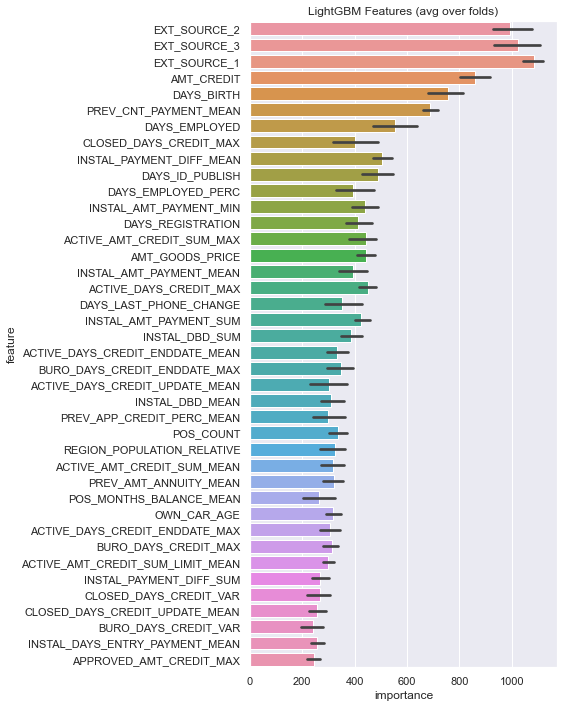

In [99]:
# Run kfold_lightgbm with dataframe df_corr002
startTime = time.time()

feature_importance_df_corr002, test_df_target_corr002 = kfold_lightgbm(df = df_corr002,
                                                                       num_folds = 5,
                                                                       stratified = True,
                                                                       debug = False)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

executionTime_min = executionTime / 60
print('Execution time in minutes: ' + str(executionTime_min))

In [105]:
# Replace NaN by median in df_corr002

# Only columns with NaNs count and percentage in bureau_df dataset
columns = df_corr002.isnull().sum()[df_corr002.isnull().sum() != 0].keys()
nans_count = df_corr002.isnull().sum()[df_corr002.isnull().sum() != 0].values
nans_percentage = df_corr002.isnull().sum()[df_corr002.isnull().sum() != 0].values/df_corr002.shape[0]

# create a dataframe from the extracted info. 
nans_df_002 = pd.DataFrame({'Column': columns, 'No. of NaNs': nans_count, 
                        '% of NaNs in Column':nans_percentage * 100})
nans_df_002 = nans_df_002.sort_values(by = '% of NaNs in Column', 
                              ascending = False)
nans_df_002

,Column,No. of NaNs,% of NaNs in Column
214,REFUSED_RATE_DOWN_PAYMENT_MIN,303648,85.234287
210,REFUSED_RATE_DOWN_PAYMENT_MAX,303648,85.234287
217,REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,85.234287
35,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,284559,79.875986
54,CC_CNT_DRAWINGS_POS_CURRENT_VAR,284559,79.875986
...,...,...,...
87,DEF_30_CNT_SOCIAL_CIRCLE,1050,0.294736
90,DEF_60_CNT_SOCIAL_CIRCLE,1050,0.294736
241,EXT_SOURCE_2,668,0.187508
215,AMT_GOODS_PRICE,278,0.078035


In [106]:
# Create the list of features with NaN
list_feat_NaN = nans_df_002['Column'].values.tolist()
len(list_feat_NaN)

243

In [107]:
# Replace NaN by median in df_corr002
for col in list_feat_NaN:
    df_corr002[col] = df_corr002[col].fillna(df_corr002[col].median())

In [109]:
# find the most correlated columns for TARGET:
# Drop non informative features 'index' and 'SK_ID_CURR' and then process correlation calculation
data_corr_002 = df_corr002.drop(['index', 'SK_ID_CURR'] ,1).corr()
# Sort values by correlation coefficient with 'TARGET'
data_corr_002 = data_corr_002.sort_values(by = 'TARGET', ascending = False)[['TARGET']]
# Create new columns
# Use index names in the new column 'Column'
data_corr_002['Column'] = data_corr_002.index
# New feature with the absolute values of correlation coefficient with 'TARGET'
data_corr_002['absTARGET'] = abs(data_corr_002['TARGET'])
data_corr_002.sort_values(by = 'absTARGET', ascending = False)

,TARGET,Column,absTARGET
TARGET,1.000000,TARGET,1.000000
EXT_SOURCE_2,-0.149737,EXT_SOURCE_2,0.149737
EXT_SOURCE_3,-0.142344,EXT_SOURCE_3,0.142344
EXT_SOURCE_1,-0.089475,EXT_SOURCE_1,0.089475
BURO_DAYS_CREDIT_MEAN,0.076731,BURO_DAYS_CREDIT_MEAN,0.076731
...,...,...,...
REFUSED_AMT_CREDIT_MIN,-0.002869,REFUSED_AMT_CREDIT_MIN,0.002869
REFUSED_RATE_DOWN_PAYMENT_MIN,-0.002842,REFUSED_RATE_DOWN_PAYMENT_MIN,0.002842
REFUSED_RATE_DOWN_PAYMENT_MEAN,-0.001564,REFUSED_RATE_DOWN_PAYMENT_MEAN,0.001564
REFUSED_AMT_GOODS_PRICE_MIN,-0.000998,REFUSED_AMT_GOODS_PRICE_MIN,0.000998


### Display correlation with TARGET by % of NaNs in each Column (or importance)

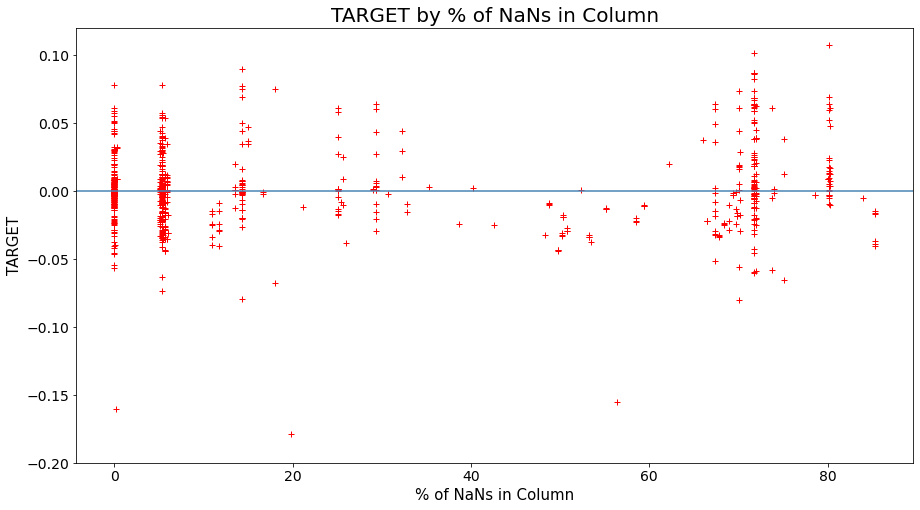

In [37]:
# Observation de l'évolution de TARGET en fonction de % of NaNs in Column
plt.figure(figsize=(15,8))
plt.plot(nans_df['% of NaNs in Column'],nans_df['TARGET'], "r+")
plt.axhline(y = 0, color = 'steelblue')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("% of NaNs in Column",
          size = 15)
plt.ylabel("TARGET",
          size = 15)
plt.title("TARGET by % of NaNs in Column",
         size=20)
plt.ylim(bottom=-0.2, top=0.12)
plt.show()

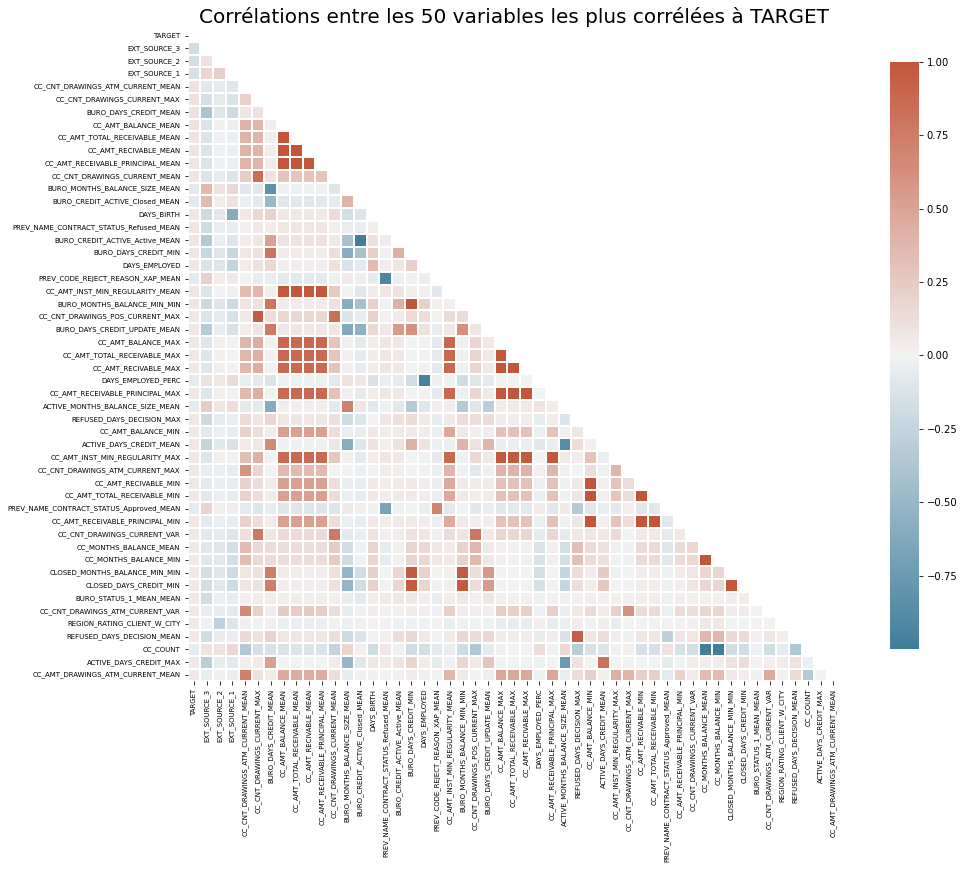

In [38]:
# View the correlation between the 50 most correlated features with TARGET

# Create the list of the 50 most correlated features with TARGET
list_most_correlated_feat = data_corr.sort_values(by = 'absTARGET', ascending = False).head(51).index.tolist()
# Create the dataframe with the 50 most correlated features
data_50_most_corr = train_df[list_most_correlated_feat]
# compute the correlation matrix
corr = data_50_most_corr[list_most_correlated_feat].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18,12))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
colormap = sns.heatmap(corr, 
                       annot=False,
                       mask=mask, 
                       cmap=cmap, 
                       vmax=1, 
                       center=0,
                       square=True, 
                       linewidths=2, 
                       cbar_kws={"shrink": .9})
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 7, rotation = 90)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 7)

plt.title('Corrélations entre les 50 variables les plus corrélées à TARGET', size = 20);

### Dataframe without columns with more than 40% of NaN

In [39]:
# Create a list of features with more than 40% of NaN
list_feat_nan40 = nans_df.loc[nans_df['% of NaNs in Column'] >= 40]['Column'].values.tolist()
len(list_feat_nan40)

245

In [40]:
# Create a dataframe without features with more than 40% of NaN
df_nan40 = df.drop(list_feat_nan40, axis = 1)
df_nan40

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,...,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.000000,1.000000,1.000000,NaN,0.00,0.0,0.00,179055.000,179055.0,179055.0000,9.0,9.0,9.000000,0.000000,0.000000,0.000000,-606.0,-606.0,-606.000000,24.000000,24.0,-1.0,-10.000000,19.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.0,2.0,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.000000,19.0,0.000000,0.000,0.000000,0.000,0.000000e+00,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.868825,1.011109,0.949329,0.005324,0.00,6885.0,3442.50,68809.500,900000.0,435436.5

### Fill NaN with median values

In [57]:
# Split df_nan40 into train and test
train_df_nan40 = df_nan40.loc[df_nan40['TARGET'].notnull()]
test_df_nan40 = df_nan40[df_nan40['TARGET'].isnull()]

In [59]:
# NaNs count and percentage in train_df_nan40
columns = train_df_nan40.isnull().sum().keys()
nans_count = train_df_nan40.isnull().sum().values
nans_percentage = train_df_nan40.isnull().sum().values/train_df_nan40.shape[0]

# create a dataframe from the extracted info. 
train_df_nan40_percentage = pd.DataFrame({'Column': columns, 'No. of NaNs': nans_count,
                               '% of NaNs in Column':nans_percentage * 100})
train_df_nan40_percentage = train_df_nan40_percentage.sort_values(by = '% of NaNs in Column',
                                            ascending = False)
train_df_nan40_percentage

,Column,No. of NaNs,% of NaNs in Column
266,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,118783,38.627739
286,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,108539,35.296432
263,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,100997,32.843805
262,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,100997,32.843805
255,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,99324,32.299753
...,...,...,...
134,ORGANIZATION_TYPE_Emergency,0,0.000000
133,ORGANIZATION_TYPE_Electricity,0,0.000000
132,ORGANIZATION_TYPE_Culture,0,0.000000
131,ORGANIZATION_TYPE_Construction,0,0.000000


In [60]:
# Create the list of features with NaN in train_df_nan40
list_feat_NaN = train_df_nan40_percentage.loc[train_df_nan40_percentage['No. of NaNs'] != 0]['Column'].values.tolist()
len(list_feat_NaN)

371

In [62]:
# Replace NaN by median in train_df_nan40
for col in list_feat_NaN:
    train_df_nan40[col] = train_df_nan40[col].fillna(train_df_nan40[col].median())

In [65]:
train_df_nan40.to_csv('train_df_nan40.csv')

### lgbm Classifier

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

X = train_df_nan40.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y = train_df_nan40['TARGET'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 0)

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state=11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [0.25]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
grid_search.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score = grid_search.best_score_
print('cv_score:', cv_score)

cv_results = grid_search.cv_results_
df_lgbmc = pd.DataFrame(cv_results)
df_lgbmc

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END smote__sampling_strategy=0.25;, score=(train=0.808, test=0.770) total time=  36.7s
[CV 2/5] END smote__sampling_strategy=0.25;, score=(train=0.808, test=0.766) total time=  33.7s
[CV 3/5] END smote__sampling_strategy=0.25;, score=(train=0.809, test=0.768) total time=  33.6s
[CV 4/5] END smote__sampling_strategy=0.25;, score=(train=0.806, test=0.773) total time=  32.8s
[CV 5/5] END smote__sampling_strategy=0.25;, score=(train=0.808, test=0.769) total time=  34.3s
Execution time in seconds: 221.60716819763184
Execution time in minutes: 3.693452803293864
cv_score: 0.7693594410024474


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,33.755965,1.276573,0.563121,0.069709,0.25,{'smote__sampling_strategy': 0.25},0.770393,0.766447,0.768377,0.772662,0.768919,0.769359,0.002079,1,0.808362,0.808159,0.809106,0.806433,0.808151,0.808042,0.000877


roc_auc_score = 0.5133198694343076
----------------
classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.50      0.03      0.06      4965

    accuracy                           0.92     61502
   macro avg       0.71      0.51      0.51     61502
weighted avg       0.89      0.92      0.88     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

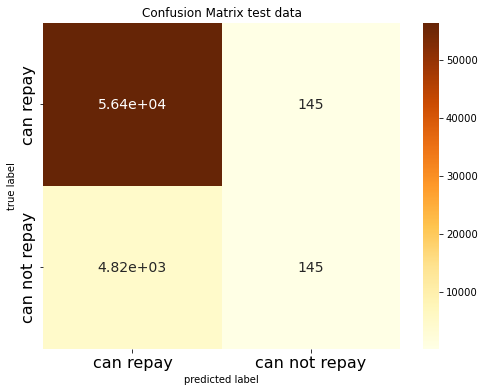

In [80]:
# Evaluate model with best parameters on X_test
bestimator = grid_search.best_estimator_
y_pred = bestimator.predict(X_test)

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
            ylabel = 'true label',
            title = 'Confusion Matrix test data')

In [82]:
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state=11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'classifier__n_estimators' : [100]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
grid_search.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score = grid_search.best_score_
print('cv_score:', cv_score)

cv_results = grid_search.cv_results_
df_lgbmc = pd.DataFrame(cv_results)
df_lgbmc

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__n_estimators=100;, score=(train=0.838, test=0.774) total time=  16.6s
[CV 2/5] END classifier__n_estimators=100;, score=(train=0.839, test=0.774) total time=  16.7s
[CV 3/5] END classifier__n_estimators=100;, score=(train=0.839, test=0.774) total time=  16.7s
[CV 4/5] END classifier__n_estimators=100;, score=(train=0.838, test=0.779) total time=  16.4s
[CV 5/5] END classifier__n_estimators=100;, score=(train=0.838, test=0.772) total time=  15.9s
Execution time in seconds: 110.46925377845764
Execution time in minutes: 1.8411542296409606
cv_score: 0.7748292704127995


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,16.060965,0.274371,0.487301,0.072486,100,{'classifier__n_estimators': 100},0.774245,0.773956,0.77409,0.779492,0.772362,0.774829,0.002428,1,0.837587,0.839326,0.83915,0.838336,0.838471,0.838574,0.000622


roc_auc_score = 0.5174256639606523
----------------
classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.54      0.04      0.07      4965

    accuracy                           0.92     61502
   macro avg       0.73      0.52      0.51     61502
weighted avg       0.89      0.92      0.89     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

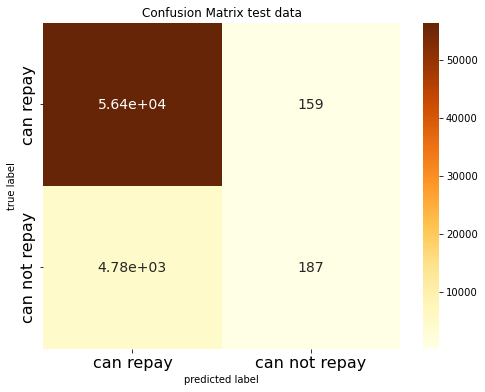

In [83]:
# Evaluate model with best parameters on X_test
bestimator = grid_search.best_estimator_
y_pred = bestimator.predict(X_test)

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
            ylabel = 'true label',
            title = 'Confusion Matrix test data')

In [121]:
X = train_df_nan40.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y = train_df_nan40['TARGET'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

In [122]:
import collections
print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({0.0: 226145, 1.0: 19860})
Counter({0.0: 56537, 1.0: 4965})


In [126]:
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state=11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'classifier__n_estimators' : [100]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
grid_search.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score = grid_search.best_score_
print('cv_score:', cv_score)

cv_results = grid_search.cv_results_
df_lgbmc = pd.DataFrame(cv_results)
df_lgbmc

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__n_estimators=100;, score=(train=0.839, test=0.771) total time=  40.1s
[CV 2/5] END classifier__n_estimators=100;, score=(train=0.840, test=0.768) total time=  24.4s
[CV 3/5] END classifier__n_estimators=100;, score=(train=0.837, test=0.776) total time=  23.7s
[CV 4/5] END classifier__n_estimators=100;, score=(train=0.838, test=0.779) total time=  23.1s
[CV 5/5] END classifier__n_estimators=100;, score=(train=0.838, test=0.779) total time=  20.6s
Execution time in seconds: 168.5581772327423
Execution time in minutes: 2.8093029538790386
cv_score: 0.7746030466821888


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,25.771284,6.835946,0.719707,0.184168,100,{'classifier__n_estimators': 100},0.77069,0.768173,0.775877,0.779462,0.778813,0.774603,0.004463,1,0.838687,0.839816,0.836931,0.83792,0.837768,0.838225,0.000972


In [108]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ['classifier',
                 LGBMClassifier(n_estimators=200, random_state=11)]])

In [128]:
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import auc

# Evaluate model with best parameters on X_test
y_pred = grid_search.predict(X_test)

# Calculate and print roc_auc score
print('roc_auc_score =', auc(y_test, y_pred))
print('----------------')

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
            ylabel = 'true label',
            title = 'Confusion Matrix test data')

ValueError: x is neither increasing nor decreasing : [0. 0. 0. ... 0. 1. 0.].

In [118]:
# Evaluate model with best parameters on X_test

y_pred = bestimator.predict_proba(X_test)

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
            ylabel = 'true label',
            title = 'Confusion Matrix test data')

ValueError: y should be a 1d array, got an array of shape (61502, 2) instead.

In [86]:
pipeline = Pipeline(steps = [['smote', SMOTE()],
                             ['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state=11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'classifier__n_estimators' : [1000]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
grid_search.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score = grid_search.best_score_
print('cv_score:', cv_score)

cv_results = grid_search.cv_results_
df_lgbmc = pd.DataFrame(cv_results)
df_lgbmc

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__n_estimators=1000;, score=(train=0.986, test=0.766) total time= 1.8min
[CV 2/5] END classifier__n_estimators=1000;, score=(train=0.987, test=0.766) total time= 1.8min
[CV 3/5] END classifier__n_estimators=1000;, score=(train=0.986, test=0.764) total time= 1.8min
[CV 4/5] END classifier__n_estimators=1000;, score=(train=0.986, test=0.774) total time= 1.8min
[CV 5/5] END classifier__n_estimators=1000;, score=(train=0.985, test=0.764) total time= 2.1min
Execution time in seconds: 718.9969625473022
Execution time in minutes: 11.983282709121704
cv_score: 0.7667709418849321


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,110.717112,8.027008,1.180378,0.169996,1000,{'classifier__n_estimators': 1000},0.765815,0.766039,0.764482,0.773666,0.763853,0.766771,0.003542,1,0.985697,0.986782,0.98646,0.986143,0.985072,0.986031,0.000599


roc_auc_score = 0.5262417693972957
----------------
classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     56537
         1.0       0.46      0.06      0.10      4965

    accuracy                           0.92     61502
   macro avg       0.69      0.53      0.53     61502
weighted avg       0.89      0.92      0.89     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

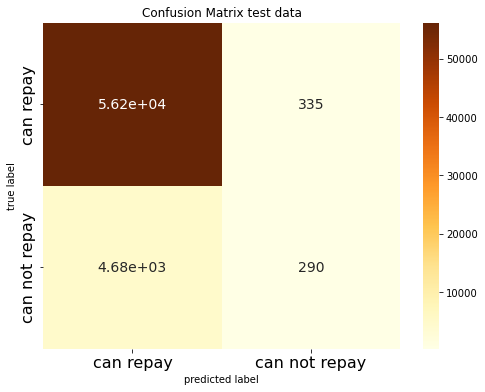

In [87]:
# Evaluate model with best parameters on X_test
bestimator = grid_search.best_estimator_
y_pred = bestimator.predict(X_test)

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
            ylabel = 'true label',
            title = 'Confusion Matrix test data')

In [ ]:
X = train_df_nan40.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y = train_df_nan40['TARGET'].values

In [115]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm_noopt(df, num_folds, stratified = False, debug= False):

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    else:
        folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters
        clf = LGBMClassifier(n_estimators = 1000)

        clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            eval_metric = 'auc', verbose = 200, early_stopping_rounds = 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # plot feature importance
    display_importances(feature_importance_df)
    return feature_importance_df

In [116]:
kfold_lightgbm_noopt(df = train_df_nan40, num_folds = 5, stratified = True, debug= False)

LightGBMError: bad allocation

In [ ]:
train_df_nan40

### Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

X = train_df_nan40.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y = train_df_nan40['TARGET'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 0)

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [0.25],
              'classifier__C' : [0.5],
              'classifier__solver' : ['lbfgs'],
              'classifier__max_iter' : [5000]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
grid_search.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score = grid_search.best_score_
print('cv_score:', cv_score)

cv_results = grid_search.cv_results_
df = pd.DataFrame(cv_results)
df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.773, test=0.766) total time= 2.0min
[CV 2/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.773, test=0.766) total time= 1.9min
[CV 3/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.774, test=0.765) total time= 1.9min
[CV 4/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.772, test=0.769) total time= 1.9min
[CV 5/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.773, test=0.765) total time= 1.9min
Execution time in seconds: 725.7166881561279
Execution time in minutes: 12.095278135935466
cv_score: 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,115.402963,2.837771,0.323803,0.025985,0.5,5000,lbfgs,0.25,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.765661,0.766372,0.764604,0.769034,0.76467,0.766068,0.001622,1,0.773127,0.772919,0.773846,0.772333,0.773438,0.773133,0.000507


roc_auc_score = 0.5112335938566089
----------------
classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.51      0.02      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.71      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

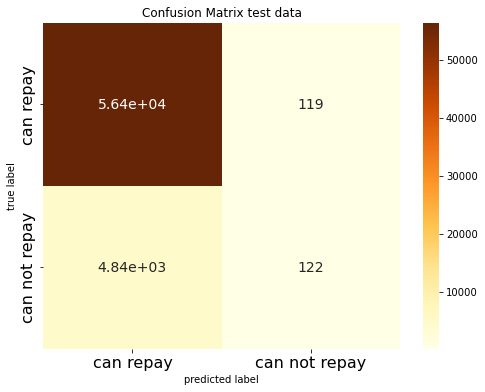

In [75]:
# Evaluate model with best parameters on X_test
bestimator = grid_search.best_estimator_
y_pred = bestimator.predict(X_test)

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
            ylabel = 'true label',
            title = 'Confusion Matrix test data')

In [76]:
# Define true positives, false positives, false negatives and true negatives
TP = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TN = conf_mat[1][1]

# Define business cost function
cost = 10 * FN + FP

In [77]:
TP

56418

### Gaussian Naive Bayes

In [66]:
from sklearn.naive_bayes import GaussianNB

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

gnb = GaussianNB()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = {}

grid_search = GridSearchCV(estimator=gnb,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.6091223724235996
best_params: {}


In [67]:
from sklearn.naive_bayes import GaussianNB

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

gnb = GaussianNB()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = {}

grid_search = GridSearchCV(estimator=gnb,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train_scaled, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.6456881506601417
best_params: {}


In [68]:
from sklearn.naive_bayes import GaussianNB

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

gnb = GaussianNB()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = {}

grid_search = GridSearchCV(estimator=gnb,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train_scaled, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.6456871531651192
best_params: {}


### AdaBoost classifier

In [69]:
from sklearn.ensemble import AdaBoostClassifier

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

abc = AdaBoostClassifier()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = {}

grid_search = GridSearchCV(estimator=abc,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.7515150272659312
best_params: {}


In [70]:
from sklearn.ensemble import AdaBoostClassifier

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

abc = AdaBoostClassifier()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = {}

grid_search = GridSearchCV(estimator=abc,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train_scaled, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.7517466537439135
best_params: {}


In [71]:
from sklearn.ensemble import AdaBoostClassifier

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

abc = AdaBoostClassifier()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = {}

grid_search = GridSearchCV(estimator=abc,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train_scaled, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.7515490107282059
best_params: {}


### MLPClassifier

In [72]:
from sklearn.neural_network import MLPClassifier

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

mlpc = MLPClassifier()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

param_grid = {}

grid_search = GridSearchCV(estimator=mlpc,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.5000726211758566
best_params: {}


In [73]:
from sklearn.neural_network import MLPClassifier

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

mlpc = MLPClassifier()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = {}

grid_search = GridSearchCV(estimator=mlpc,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train_scaled, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.7280236282474135
best_params: {}


### RandomForestClassifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

rfc = RandomForestClassifier()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

param_grid = {}

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.7175096314188882
best_params: {}


In [100]:
from sklearn.ensemble import RandomForestClassifier

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

rfc = RandomForestClassifier()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

param_grid = {}

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train_scaled, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.7181763254974084
best_params: {}


In [101]:
## Import Modules
import numpy as np
import pandas as pd
import os
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

In [102]:
df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

In [105]:
## Scaling
scaler = preprocessing.StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)

columns = X_train.columns

## Over-sampling training data using SMOTE
os = SMOTE(sampling_strategy = 0.3, random_state=0)
os_X_train, os_y_train = os.fit_resample(X_train_scaled, y_train)
X_train_scaled

os_data_X = pd.DataFrame(data=os_X_train,columns=columns)
os_data_y = pd.DataFrame(data=os_y_train,columns=['y'])

# Oversampling report
print("\nBalancing data with synthetic data..")
print("\nLength of synthetic training data:",(len(os_data_X) - len(X_train)))
print("Length of original training data:",len(X_train))
print("Length of oversampled training data:",len(os_data_X))
print("Proportion of negative examples in original data:", round(len(y_train[y_train==1])/len(y_train), 3))
print("Proportion of negative examples in oversampled data:",len(os_data_y[os_data_y['y']==1])/len(os_data_X))


Balancing data with synthetic data..

Length of synthetic training data: 59979
Length of original training data: 307507
Length of oversampled training data: 367486
Proportion of negative examples in original data: 0.081
Proportion of negative examples in oversampled data: 0.23076797483441547


In [107]:
# Set the parameters by cross-validation
param_grid = {'C' : [0.05, 0.1, 0.2],
              'solver' : ['newton-cg']}

## Add different measures for optimisation
scores = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

### Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

In [108]:
### Fitting Models

for score in scores:
    
    print("Tuning hyper-parameters for %s ..." % score)
    print()
    lr = LogisticRegression(random_state=11)
    clf_lr = GridSearchCV(lr,
                          param_grid, 
                          cv = stratified_kfold,
                          scoring = score)
    grid = clf_lr.fit(os_data_X, np.ravel(os_data_y))
    print("GridSearchCV Grid scores on development set (not on test set):")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)

Tuning hyper-parameters for accuracy ...

GridSearchCV Grid scores on development set (not on test set):

0.785 (+/-0.002) for {'C': 0.05, 'solver': 'newton-cg'}
0.785 (+/-0.002) for {'C': 0.1, 'solver': 'newton-cg'}
0.785 (+/-0.001) for {'C': 0.2, 'solver': 'newton-cg'}

Best parameters set found on development set:

{'C': 0.2, 'solver': 'newton-cg'}
Tuning hyper-parameters for roc_auc ...

GridSearchCV Grid scores on development set (not on test set):

0.769 (+/-0.002) for {'C': 0.05, 'solver': 'newton-cg'}
0.769 (+/-0.002) for {'C': 0.1, 'solver': 'newton-cg'}
0.769 (+/-0.002) for {'C': 0.2, 'solver': 'newton-cg'}

Best parameters set found on development set:

{'C': 0.2, 'solver': 'newton-cg'}
Tuning hyper-parameters for f1 ...



KeyboardInterrupt: 

In [122]:
from imblearn.pipeline import Pipeline

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 0.75, 1],
              'classifier__C' : [0.05, 0.1, 0.2, 0.5],
              'classifier__solver' : ['newton-cg', 'lbfgs'],
              'classifier__max_iter' : [5000]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold)

startFitTime = time.time()
grid_search.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score = grid_search.best_score_
print('cv_score:', cv_score)

cv_results = grid_search.cv_results_
df = pd.DataFrame(cv_results)
df

Execution time in seconds: 4471.953373670578
Execution time in minutes: 74.53255622784296
cv_score: 0.7454642202627315


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,42.397745,36.477739,0.099733,0.054906,0.05,5000,newton-cg,0.25,"{'classifier__C': 0.05, 'classifier__max_iter'...",0.744355,0.743803,0.749791,0.744623,0.744556,0.745426,0.002201,8
1,28.587283,1.474915,0.076197,0.007689,0.05,5000,newton-cg,0.5,"{'classifier__C': 0.05, 'classifier__max_iter'...",0.741815,0.740767,0.746962,0.742035,0.741930,0.742702,0.002178,15
2,34.387997,1.262690,0.070207,0.002412,0.05,5000,newton-cg,0.75,"{'classifier__C': 0.05, 'classifier__max_iter'...",0.741124,0.740090,0.746304,0.741445,0.741293,0.742051,0.002179,23
3,39.354693,2.048348,0.072607,0.003954,0.05,5000,newton-cg,1,"{'classifier__C': 0.05, 'classifier__max_iter'...",0.740991,0.739871,0.745916,0.741175,0.741256,0.741842,0.002097,31
4,14.260972,0.192017,0.069414,0.003867,0.05,5000,lbfgs,0.25,"{'classifier__C': 0.05, 'classifier__max_iter'...",0.744353,0.743804,0.749791,0.744625,0.744558,0.745426,0.002201,7
5,16.737329,0.621209,0.073211,0.006633,0.05,5000,lbfgs,0.5,"{'classifier__C': 0.05, 'classifier__max_iter'...",0.741813,0.740765,0.746966,0.742034,0.741929,0.742702,0.002180,16
6,18.719536,0.649772,0.070610,0.002311,0.05,5000,lbfgs,0.75,"{'classifier__C': 0.05, 'classifier__max_iter'...",0.741124,0.740087,0.746305,0.741445,0.741293,0.742051,0.002180,24
7,20.536514,0.736381,0.074006,0.008860,0.05,5000,lbfgs,1,"{'classifier__C': 0.05, 'classifier__max_iter'...",0.740992,0.739872,0.745915,0.741172,0.741255,0.741841,0.002097,32
8,26.038755,2.303059,0.070422,0.003005,0.1,5000,newton-cg,0.25,"{'classifier__C': 0.1, 'classifier__max_iter':...",0.744383,0.743810,0.749817,0.744635,0.744592,0.745448,0.002205,6
9,33.140635,0.953727,0.069210,0.000482,0.1,5000,newton-cg,0.5,"{'classifier__C': 0.1, 'classifier__max_iter':...",0.741837,0.740771,0.746984,0.742041,0.741954,0.742718,0.002182,13


In [123]:
# Code to display all columns and all texts
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 20
    display.max_rows = 100
    display.max_colwidth = 300
    display.width = None
set_pandas_display_options()

In [125]:
df.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
28,15.886906,0.782118,0.074401,0.009369,0.5,5000,lbfgs,0.25,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744403,0.743811,0.749844,0.744626,0.744637,0.745464,0.002210,1
24,33.430920,0.932554,0.072407,0.003919,0.5,5000,newton-cg,0.25,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744405,0.743813,0.749838,0.744625,0.744639,0.745464,0.002208,2
20,15.285660,0.322102,0.081986,0.009589,0.2,5000,lbfgs,0.25,"{'classifier__C': 0.2, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744398,0.743814,0.749834,0.744637,0.744619,0.745460,0.002207,3
16,28.959747,2.737443,0.073207,0.004829,0.2,5000,newton-cg,0.25,"{'classifier__C': 0.2, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744398,0.743813,0.749831,0.744633,0.744619,0.745459,0.002206,4
12,14.814398,0.303162,0.077194,0.010827,0.1,5000,lbfgs,0.25,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744384,0.743808,0.749820,0.744636,0.744595,0.745448,0.002206,5
8,26.038755,2.303059,0.070422,0.003005,0.1,5000,newton-cg,0.25,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744383,0.743810,0.749817,0.744635,0.744592,0.745448,0.002205,6
4,14.260972,0.192017,0.069414,0.003867,0.05,5000,lbfgs,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744353,0.743804,0.749791,0.744625,0.744558,0.745426,0.002201,7
0,42.397745,36.477739,0.099733,0.054906,0.05,5000,newton-cg,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744355,0.743803,0.749791,0.744623,0.744556,0.745426,0.002201,8
29,17.774251,0.800099,0.071210,0.003868,0.5,5000,lbfgs,0.5,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.5}",0.741856,0.740762,0.747003,0.742043,0.741975,0.742728,0.002188,9
25,38.023408,2.543100,0.073798,0.004850,0.5,5000,newton-cg,0.5,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.5}",0.741857,0.740767,0.746997,0.742038,0.741979,0.742728,0.002185,10


In [120]:
pipeline.get_params()

{'memory': None,
 'steps': [['smote', SMOTE(sampling_strategy=0.25)],
  ['scaler', StandardScaler()],
  ['classifier', LogisticRegression()]],
 'verbose': False,
 'smote': SMOTE(sampling_strategy=0.25),
 'scaler': StandardScaler(),
 'classifier': LogisticRegression(),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': None,
 'smote__sampling_strategy': 0.25,
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 1.0,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [126]:
from imblearn.pipeline import Pipeline

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 0.75, 1],
              'classifier__C' : [0.05, 0.1, 0.2, 0.5],
              'classifier__solver' : ['newton-cg', 'lbfgs'],
              'classifier__max_iter' : [5000]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
grid_search.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score = grid_search.best_score_
print('cv_score:', cv_score)

cv_results = grid_search.cv_results_
df = pd.DataFrame(cv_results)
df

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END classifier__C=0.05, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.25;, score=(train=0.747, test=0.744) total time=  29.7s
[CV 2/5] END classifier__C=0.05, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.25;, score=(train=0.746, test=0.744) total time=  25.6s
[CV 3/5] END classifier__C=0.05, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.25;, score=(train=0.746, test=0.750) total time=  23.5s
[CV 4/5] END classifier__C=0.05, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.25;, score=(train=0.747, test=0.745) total time=  23.3s
[CV 5/5] END classifier__C=0.05, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.25;, score=(train=0.747, test=0.745) total time=  26.3s
[CV 1/5] END classifier__C=0.05, classifier__max_iter=5000, classifier__s

[CV 4/5] END classifier__C=0.1, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.5;, score=(train=0.744, test=0.742) total time=  34.8s
[CV 5/5] END classifier__C=0.1, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.5;, score=(train=0.744, test=0.742) total time=  33.0s
[CV 1/5] END classifier__C=0.1, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.75;, score=(train=0.744, test=0.741) total time=  38.2s
[CV 2/5] END classifier__C=0.1, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.75;, score=(train=0.743, test=0.740) total time=  37.7s
[CV 3/5] END classifier__C=0.1, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.75;, score=(train=0.743, test=0.746) total time=  35.9s
[CV 4/5] END classifier__C=0.1, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=0.75;, score=(train=0.743, t

[CV 3/5] END classifier__C=0.2, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=1;, score=(train=0.743, test=0.746) total time=  45.2s
[CV 4/5] END classifier__C=0.2, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=1;, score=(train=0.743, test=0.741) total time=  48.6s
[CV 5/5] END classifier__C=0.2, classifier__max_iter=5000, classifier__solver=newton-cg, smote__sampling_strategy=1;, score=(train=0.743, test=0.741) total time=  44.0s
[CV 1/5] END classifier__C=0.2, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.747, test=0.744) total time=  14.9s
[CV 2/5] END classifier__C=0.2, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.746, test=0.744) total time=  15.1s
[CV 3/5] END classifier__C=0.2, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.746, test=0.750) total ti

[CV 2/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.5;, score=(train=0.743, test=0.741) total time=  18.6s
[CV 3/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.5;, score=(train=0.744, test=0.747) total time=  16.7s
[CV 4/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.5;, score=(train=0.744, test=0.742) total time=  17.2s
[CV 5/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.5;, score=(train=0.744, test=0.742) total time=  20.2s
[CV 1/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.75;, score=(train=0.744, test=0.741) total time=  22.0s
[CV 2/5] END classifier__C=0.5, classifier__max_iter=5000, classifier__solver=lbfgs, smote__sampling_strategy=0.75;, score=(train=0.743, test=0.740) total time=  19

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,25.685433,2.309791,0.085972,0.016761,0.05,5000,newton-cg,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744355,...,0.745426,0.002201,8,0.747440,0.746166,0.746279,0.746780,0.746762,0.746686,0.000451
1,29.464868,1.999863,0.077791,0.012679,0.05,5000,newton-cg,0.5,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.5}",0.741815,...,0.742702,0.002178,15,0.744665,0.743437,0.743473,0.744123,0.743878,0.743915,0.000454
2,33.442871,1.189949,0.073211,0.002998,0.05,5000,newton-cg,0.75,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.75}",0.741124,...,0.742051,0.002179,23,0.743993,0.742930,0.742981,0.743443,0.743179,0.743305,0.000388
3,39.845754,2.075301,0.074990,0.002468,0.05,5000,newton-cg,1,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 1}",0.740991,...,0.741842,0.002097,31,0.743853,0.742822,0.742749,0.743176,0.743192,0.743158,0.000391
4,14.273059,0.240666,0.069215,0.003816,0.05,5000,lbfgs,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744353,...,0.745426,0.002201,7,0.747438,0.746166,0.746280,0.746781,0.746761,0.746685,0.000451
5,17.177252,0.665327,0.071220,0.002858,0.05,5000,lbfgs,0.5,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.5}",0.741813,...,0.742702,0.002180,16,0.744665,0.743434,0.743476,0.744125,0.743879,0.743916,0.000454
6,18.673059,0.356900,0.075398,0.004746,0.05,5000,lbfgs,0.75,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.75}",0.741124,...,0.742051,0.002180,24,0.743993,0.742928,0.742981,0.743442,0.743179,0.743305,0.000389
7,20.582704,0.628787,0.074402,0.004304,0.05,5000,lbfgs,1,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 1}",0.740992,...,0.741841,0.002097,32,0.743851,0.742822,0.742747,0.743175,0.743188,0.743157,0.000391
8,27.565228,2.298353,0.078790,0.012345,0.1,5000,newton-cg,0.25,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744383,...,0.745448,0.002205,6,0.747467,0.746192,0.746304,0.746811,0.746785,0.746712,0.000452
9,82.041561,94.806818,0.093948,0.032027,0.1,5000,newton-cg,0.5,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.5}",0.741837,...,0.742718,0.002182,13,0.744683,0.743457,0.743490,0.744146,0.743895,0.743934,0.000454


In [127]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,25.685433,2.309791,0.085972,0.016761,0.05,5000,newton-cg,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744355,...,0.745426,0.002201,8,0.747440,0.746166,0.746279,0.746780,0.746762,0.746686,0.000451
1,29.464868,1.999863,0.077791,0.012679,0.05,5000,newton-cg,0.5,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.5}",0.741815,...,0.742702,0.002178,15,0.744665,0.743437,0.743473,0.744123,0.743878,0.743915,0.000454
2,33.442871,1.189949,0.073211,0.002998,0.05,5000,newton-cg,0.75,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.75}",0.741124,...,0.742051,0.002179,23,0.743993,0.742930,0.742981,0.743443,0.743179,0.743305,0.000388
3,39.845754,2.075301,0.074990,0.002468,0.05,5000,newton-cg,1,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 1}",0.740991,...,0.741842,0.002097,31,0.743853,0.742822,0.742749,0.743176,0.743192,0.743158,0.000391
4,14.273059,0.240666,0.069215,0.003816,0.05,5000,lbfgs,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744353,...,0.745426,0.002201,7,0.747438,0.746166,0.746280,0.746781,0.746761,0.746685,0.000451
5,17.177252,0.665327,0.071220,0.002858,0.05,5000,lbfgs,0.5,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.5}",0.741813,...,0.742702,0.002180,16,0.744665,0.743434,0.743476,0.744125,0.743879,0.743916,0.000454
6,18.673059,0.356900,0.075398,0.004746,0.05,5000,lbfgs,0.75,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.75}",0.741124,...,0.742051,0.002180,24,0.743993,0.742928,0.742981,0.743442,0.743179,0.743305,0.000389
7,20.582704,0.628787,0.074402,0.004304,0.05,5000,lbfgs,1,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 1}",0.740992,...,0.741841,0.002097,32,0.743851,0.742822,0.742747,0.743175,0.743188,0.743157,0.000391
8,27.565228,2.298353,0.078790,0.012345,0.1,5000,newton-cg,0.25,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744383,...,0.745448,0.002205,6,0.747467,0.746192,0.746304,0.746811,0.746785,0.746712,0.000452
9,82.041561,94.806818,0.093948,0.032027,0.1,5000,newton-cg,0.5,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.5}",0.741837,...,0.742718,0.002182,13,0.744683,0.743457,0.743490,0.744146,0.743895,0.743934,0.000454


In [128]:
df.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
28,17.089255,0.868019,0.078592,0.008256,0.5,5000,lbfgs,0.25,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744403,...,0.745464,0.002210,1,0.747490,0.746214,0.746323,0.746840,0.746802,0.746734,0.000453
24,33.506333,1.334046,0.072606,0.002309,0.5,5000,newton-cg,0.25,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744405,...,0.745464,0.002208,2,0.747489,0.746215,0.746324,0.746843,0.746802,0.746735,0.000453
20,14.941309,0.350754,0.072008,0.003909,0.2,5000,lbfgs,0.25,"{'classifier__C': 0.2, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744398,...,0.745460,0.002207,3,0.747478,0.746205,0.746317,0.746833,0.746796,0.746726,0.000452
16,29.186034,2.607048,0.077393,0.007919,0.2,5000,newton-cg,0.25,"{'classifier__C': 0.2, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744398,...,0.745459,0.002206,4,0.747480,0.746206,0.746317,0.746831,0.746796,0.746726,0.000452
12,14.838391,0.241195,0.073344,0.008970,0.1,5000,lbfgs,0.25,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744384,...,0.745448,0.002206,5,0.747466,0.746191,0.746305,0.746810,0.746786,0.746711,0.000452
8,27.565228,2.298353,0.078790,0.012345,0.1,5000,newton-cg,0.25,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744383,...,0.745448,0.002205,6,0.747467,0.746192,0.746304,0.746811,0.746785,0.746712,0.000452
4,14.273059,0.240666,0.069215,0.003816,0.05,5000,lbfgs,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744353,...,0.745426,0.002201,7,0.747438,0.746166,0.746280,0.746781,0.746761,0.746685,0.000451
0,25.685433,2.309791,0.085972,0.016761,0.05,5000,newton-cg,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744355,...,0.745426,0.002201,8,0.747440,0.746166,0.746279,0.746780,0.746762,0.746686,0.000451
29,18.207158,1.206148,0.077585,0.005208,0.5,5000,lbfgs,0.5,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.5}",0.741856,...,0.742728,0.002188,9,0.744697,0.743467,0.743503,0.744172,0.743908,0.743950,0.000457
25,37.920437,3.935710,0.070209,0.001737,0.5,5000,newton-cg,0.5,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.5}",0.741857,...,0.742728,0.002185,10,0.744698,0.743472,0.743504,0.744167,0.743908,0.743950,0.000455


In [130]:
df.groupby('param_classifier__solver').mean()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
param_classifier__solver,,,,,,,,,,,,,,,,,,,
lbfgs,20.627542,4.780660,0.076155,0.007407,0.742093,0.741135,0.747266,0.742323,0.742287,0.743021,0.002168,16.5,0.745006,0.743859,0.743889,0.744406,0.744269,0.744286,0.000421
newton-cg,39.719998,8.479553,0.076362,0.007634,0.742094,0.741136,0.747262,0.742323,0.742288,0.743021,0.002167,16.5,0.745007,0.743860,0.743889,0.744406,0.744270,0.744286,0.000421


In [ ]:
# Define true positives, false positives, false negatives and true negatives
TP = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TN = conf_mat[1][1]

# Define business cost function
cost = 10 * FN + FP

In [134]:
from collections import Counter
from imblearn.over_sampling import SMOTE

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(sampling_strategy = 0.25,
            random_state=42)

startFitTime = time.time()

X_res, y_res = sm.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Execution time in seconds: 11.922111749649048
Execution time in minutes: 0.1987018624941508
Resampled dataset shape Counter({0.0: 282682, 1.0: 70670})


In [136]:
from collections import Counter
from imblearn.over_sampling import ADASYN

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

adasyn = ADASYN(sampling_strategy = 0.25,
                random_state=42)

startFitTime = time.time()

X_res, y_res = adasyn.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Execution time in seconds: 142.3265814781189
Execution time in minutes: 2.3721096913019815
Resampled dataset shape Counter({0.0: 282682, 1.0: 71946})


In [137]:
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

bordersm = BorderlineSMOTE(sampling_strategy = 0.25,
                           random_state=42)

startFitTime = time.time()

X_res, y_res = bordersm.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Execution time in seconds: 138.6216516494751
Execution time in minutes: 2.310360860824585
Resampled dataset shape Counter({0.0: 282682, 1.0: 70670})


In [ ]:
from collections import Counter
from imblearn.over_sampling import SVMSMOTE

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

svmsm = SVMSMOTE(sampling_strategy = 0.25,
                 random_state=42)

startFitTime = time.time()

X_res, y_res = svmsm.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})


In [131]:
from collections import Counter
from imblearn.combine import SMOTEENN 

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

sme = SMOTEENN(sampling_strategy = 0.25, 
               random_state=42)

startFitTime = time.time()

X_res, y_res = sme.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Resampled dataset shape Counter({0.0: 199815, 1.0: 44558})


In [135]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek 

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

smt = SMOTETomek(sampling_strategy = 0.25, 
                 random_state=42)

startFitTime = time.time()

X_res, y_res = smt.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Execution time in seconds: 1511.8728518486023
Execution time in minutes: 25.19788086414337
Resampled dataset shape Counter({0.0: 280748, 1.0: 68736})


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

pipeline = Pipeline(steps = [['smote', SMOTEENN(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 0.75, 1],
              'classifier__C' : [0.05, 0.1, 0.2, 0.5],
              'classifier__solver' : ['newton-cg', 'lbfgs'],
              'classifier__max_iter' : [5000]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
grid_search.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score = grid_search.best_score_
print('cv_score:', cv_score)

cv_results = grid_search.cv_results_
df = pd.DataFrame(cv_results)
df